### EM solver on one patch of the cubed sphere

In [2]:
import numpy as N
import matplotlib.pyplot as P
from math import *

import sys
from figure_module import *

In [15]:
# Parameters
r = 1.0
cfl = 0.1

Nxi = 128
Neta = 128
NG = 2 # Number of ghosts zones
xi_min, xi_max = - N.pi / 4.0, N.pi / 4.0
eta_min, eta_max = - N.pi / 4.0, N.pi / 4.0
dxi = (xi_max - xi_min) / Nxi
deta = (eta_max - eta_min) / Neta

xi  = N.linspace(xi_min - NG * dxi, xi_max + NG * dxi, Nxi + 2 * NG)
eta = N.linspace(eta_min - NG * deta, eta_max + NG * deta, Neta + 2 * NG)

eta_grid, xi_grid = N.meshgrid(eta, xi)

xi_yee  = xi  + 0.5 * dxi
eta_yee = eta + 0.5 * deta

# Initialize fields
Eru = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1u = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2u = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
Bru = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1u = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2u = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

E1d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

Eru0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1u0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2u0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
Bru0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1u0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2u0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

In [4]:
# Metric tensor
g11d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g12d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g22d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))

for i in range(Nxi + 2 * NG):
    for j in range(Neta + 2 * NG):
        
        # 0 at (i, j)
        X = N.tan(xi[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 0] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 0] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 0] = - r * r * X * Y * C * C * D * D / (delta)**4
        
        # 1 at (i + 1/2, j)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 1] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 1] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 1] = - r * r * X * Y * C * C * D * D / (delta)**4
        
        # 2 at (i, j + 1/2)
        X = N.tan(xi[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 2] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 2] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 2] = - r * r * X * Y * C * C * D * D / (delta)**4

        # 3 at (i + 1/2, j + 1/2)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)

        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 3] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 3] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 3] = - r * r * X * Y * C * C * D * D / (delta)**4

sqrt_det_g = N.sqrt(g11d * g22d - g12d * g12d)
g11u = g11d / (sqrt_det_g * sqrt_det_g)
g22u = g22d / (sqrt_det_g * sqrt_det_g)
g12u = - g12d / (sqrt_det_g * sqrt_det_g)

dt = cfl * N.min(1.0 / N.sqrt(g11u / (dxi * dxi) + g22u / (deta * deta) + 2.0 * g12u / (dxi * deta)))
print("delta t = {}".format(dt))

delta t = 0.0005669125508928004


In [5]:
from itertools import chain

def contra_to_cov_E():
    
    for i in range(NG - 1, Nxi + NG + 1):
        for j in range(NG - 1, Neta + NG + 1):
            
            w1 = sqrt_det_g[i, j, 2]
            w2 = sqrt_det_g[i + 1, j - 1, 2]
            E1d[i, j] = g11d[i, j, 1] * E1u[i, j] + (w1 * g12d[i, j, 2] * E2u[i, j] + w2 * g12d[i + 1, j -1, 2] * E2u[i + 1, j - 1]) / (w1 + w2)
            
            # E1d[i, j] = g11d[i, j, 1] * E1u[i, j] + 0.5 * g12d[i, j, 1] * (E2u[i, j] + E2u[i + 1, j - 1])
            
            # E1d[i, j] = g11d[i, j, 1] * E1u[i, j] + 0.5 * (g12d[i, j, 2] * E2u[i, j] + g12d[i + 1, j - 1, 2] * E2u[i + 1, j - 1])

            w1 = sqrt_det_g[i, j, 1]
            w2 = sqrt_det_g[i - 1, j + 1, 1]
            E2d[i, j] = g22d[i, j, 2] * E2u[i, j] + (w1 * g12d[i, j, 1] * E1u[i, j] + w2 * g12d[i - 1, j + 1, 1] * E1u[i - 1, j + 1]) / (w1 + w2)
            
            # E2d[i, j] = g22d[i, j, 2] * E2u[i, j] + 0.5 * g12d[i, j, 2] * (E1u[i, j] + E1u[i - 1, j + 1])
            
            # E2d[i, j] = g22d[i, j, 2] * E2u[i, j] + 0.5 * (g12d[i, j, 1] * E1u[i, j] + g12d[i - 1, j + 1, 1] * E1u[i - 1, j + 1])

def contra_to_cov_B():
    
    for i in range(NG, Nxi + NG):
        for j in range(NG, Neta + NG):

            w1 = sqrt_det_g[i, j, 1]
            w2 = sqrt_det_g[i - 1, j + 1, 1]
            B1d[i, j] = g11d[i, j, 2] * B1u[i, j] + (w1 * g12d[i, j, 1] * B2u[i, j] + w2 * g12d[i - 1, j + 1, 1] * B2u[i - 1, j + 1]) / (w1 + w2)
            
            # B1d[i, j] = g11d[i, j, 2] * B1u[i, j] + 0.5 * g12d[i, j, 2] * (B2u[i, j] + B2u[i - 1, j + 1])
            
            # B1d[i, j] = g11d[i, j, 2] * B1u[i, j] + 0.5 * (g12d[i, j, 1] * B2u[i, j] + g12d[i - 1, j + 1, 1] * B2u[i - 1, j + 1])

            w1 = sqrt_det_g[i, j, 2]
            w2 = sqrt_det_g[i + 1, j - 1, 2]
            B2d[i, j] = g22d[i, j, 1] * B2u[i, j] + (w1 * g12d[i, j, 1] * B1u[i, j] + w2 * g12d[i + 1, j - 1, 2] * B1u[i + 1, j - 1]) / (w1 + w2)
            
            # B2d[i, j] = g22d[i, j, 1] * B2u[i, j] + 0.5 * g12d[i, j, 1] * (B1u[i, j] + B1u[i + 1, j - 1])
            
            # B2d[i, j] = g22d[i, j, 1] * B2u[i, j] + 0.5 * (g12d[i, j, 2] * B1u[i, j] + g12d[i + 1, j - 1, 2] * B1u[i + 1, j - 1])

def push_B():
    
    for i in range(NG, Nxi + NG):
        for j in range(NG, Neta + NG):
            Bru[i, j] -= ((E2d[i + 1, j] - E2d[i, j]) / dxi - (E1d[i, j + 1] - E1d[i, j]) / deta) * dt / sqrt_det_g[i, j, 3]

    for j in range(NG, Neta + NG):
        B1u[:, j] -= ((Eru[:, j + 1] - Eru[:, j]) / deta) * dt / sqrt_det_g[:, j, 2]
 
    for i in range(NG, Nxi + NG):
        B2u[i, :] += ((Eru[i + 1, :] - Eru[i, :]) / dxi) * dt / sqrt_det_g[i, :, 1]

def push_E(it):
    
    for i in range(NG, Nxi + NG):
        for j in range(NG, Neta + NG):
            Eru[i, j] += ((B2d[i, j] - B2d[i - 1, j]) / dxi - (B1d[i, j] - B1d[i, j - 1]) / deta) * dt / sqrt_det_g[i, j, 0] - 4.0 * N.pi * dt * Jr(it, i, j) 
 
    for j in range(NG, Neta + NG):
        E1u[:, j] += ((Bru[:, j] - Bru[:, j - 1]) / deta) * dt / sqrt_det_g[:, j, 1]

    for i in range(NG, Nxi + NG):
        E2u[i, :] -= ((Bru[i, :] - Bru[i - 1, :]) / dxi) * dt / sqrt_det_g[i, :, 2]

In [6]:
def BC_B_metal():
    
    for i in range(0, NG + 1):   
        B1u[i, :] = 0.0
    for i in range(0, NG):
        Bru[i, :] = 0.0
        B2u[i, :] = 0.0
    
    for i in range(Nxi + NG, Nxi + 2 * NG):
        B1u[i, :] = 0.0
        Bru[i, :] = 0.0
        B2u[i, :] = 0.0
        
    for j in range(0, NG + 1):
        B2u[:, j] = 0.0
    for j in range(0, NG):
        Bru[:, j] = 0.0
        B1u[:, j] = 0.0
        
    for j in range(Neta + NG, Neta + 2 * NG):
        B2u[:, j] = 0.0
        Bru[:, j] = 0.0
        B1u[:, j] = 0.0
           
def BC_E_metal():
    
    for i in range(0, NG + 1):        
        Eru[i, :] = 0.0
        E2u[i, :] = 0.0
    for i in range(0, NG):        
        E1u[i, :] = 0.0
        
    for i in range(Nxi + NG, Nxi + 2 * NG):
        Eru[i, :] = 0.0
        E2u[i, :] = 0.0
        E1u[i, :] = 0.0

    for j in range(0, NG + 1):
        Eru[:, j] = 0.0
        E1u[:, j] = 0.0
    for j in range(0, NG):        
        E2u[:, j] = 0.0

    for j in range(Neta + NG, Neta + 2 * NG):
        Eru[:, j] = 0.0
        E1u[:, j] = 0.0
        E2u[:, j] = 0.0

i_abs = 5

xi_abs = xi[i_abs]
delta_r = ((xi_abs - xi_grid) / (xi_abs - xi_min)) * N.heaviside(xi_abs - xi_grid, 0.0)
xi_abs = xi[Nxi + NG - i_abs]
delta_l = ((xi_grid - xi_abs) / (xi_max - xi_abs)) * N.heaviside(xi_grid - xi_abs, 0.0)

eta_abs = eta[i_abs]
delta_b = ((eta_abs - eta_grid) / (eta_abs - eta_min)) * N.heaviside(eta_abs - eta_grid, 0.0)
eta_abs = eta[Neta + NG - i_abs]
delta_u = ((eta_grid - eta_abs) / (eta_max - eta_abs)) * N.heaviside(eta_grid - eta_abs, 0.0)

sigma = N.exp(- ((delta_l**3)  + (delta_r**3) + (delta_u**3) + (delta_b**3)))

def BC_B_absorb():
    B1u[:, :] *= sigma[:, :]
    B2u[:, :] *= sigma[:, :]
    Bru[:, :] *= sigma[:, :]
           
def BC_E_absorb():
    E1u[:, :] *= sigma[:, :]
    E2u[:, :] *= sigma[:, :]
    Eru[:, :] *= sigma[:, :]

def BC_B_periodic():
    
    for i in range(0, NG):   
        Bru[i, :] = Bru[i + Nxi, :]    
        B1u[i, :] = B1u[i + Nxi, :]  
        B2u[i, :] = B2u[i + Nxi, :]   
    
    for i in range(Nxi + NG, Nxi + 2 * NG):
        Bru[i, :] = Bru[i - Nxi, :]    
        B1u[i, :] = B1u[i - Nxi, :]  
        B2u[i, :] = B2u[i - Nxi, :]   

    for j in range(0, NG):
        Bru[:, j] = Bru[:, j + Neta]
        B1u[:, j] = B1u[:, j + Neta]
        B2u[:, j] = B2u[:, j + Neta]

    for j in range(Neta + NG, Neta + 2 * NG):
        Bru[:, j] = Bru[:, j - Neta]
        B1u[:, j] = B1u[:, j - Neta]
        B2u[:, j] = B2u[:, j - Neta]

def BC_E_periodic():
    
    for i in range(0, NG):   
        Eru[i, :] = Eru[i + Nxi, :]    
        E1u[i, :] = E1u[i + Nxi, :]  
        E2u[i, :] = E2u[i + Nxi, :]   
    
    for i in range(Nxi + NG, Nxi + 2 * NG):
        Eru[i, :] = Eru[i - Nxi, :]    
        E1u[i, :] = E1u[i - Nxi, :]  
        E2u[i, :] = E2u[i - Nxi, :]   

    for j in range(0, NG):
        Eru[:, j] = Eru[:, j + Neta]
        E1u[:, j] = E1u[:, j + Neta]
        E2u[:, j] = E2u[:, j + Neta]

    for j in range(Neta + NG, Neta + 2 * NG):
        Eru[:, j] = Eru[:, j - Neta]
        E1u[:, j] = E1u[:, j - Neta]
        E2u[:, j] = E2u[:, j - Neta]

In [7]:
# Initial conditions

theta0, phi0 = 90.0 / 360.0 * 2.0 * N.pi, 90.0 / 360.0 * 2.0 * N.pi # Center of the wave packet
w = 0.1 # Radius of wave packet
amp = 0.2 # Maximal amplitude
wave = 1.0
J0 = 2.0
B0 = 0.0

def shape_packet(x, y, z, width):
    # return amp * N.exp(- y * y / (width * width)) * N.exp(- x * x / (width * width)) * N.exp(- z * z / (width * width)) 
    return amp * N.exp(- x * x / (width * width)) * N.exp(- y * y / (width * width))

for i in range(Nxi + 2 * NG):
    for j in range(Neta + 2 * NG):
        
        X = N.tan(xi[i])
        Y = N.tan(eta[j])

        theta = 0.5 * N.pi - N.arctan(Y / N.sqrt(1.0 + X * X))
        phi = N.arctan2(1.0 / N.sqrt(1.0 + X * X), X / N.sqrt(1.0 + X * X))

        x = N.sin(theta) * N.cos(phi)
        y = N.sin(theta) * N.sin(phi)
        z = N.cos(theta)
        
        x0 = N.sin(theta0) * N.cos(phi0)
        y0 = N.sin(theta0) * N.sin(phi0)
        z0 = N.cos(theta0)
        
        Eru0[i,j] = shape_packet(xi[i], eta[j], 0.0, w) # shape_packet(x - x0, y - y0, z - z0, w) # * N.cos(2.0 * N.pi * eta[j] / wave)
        B2u0[i,j] = - shape_packet(xi[i], eta[j], 0.0, w) # shape_packet(x - x0, y - y0, z - z0, w) # * N.sin(2.0 * N.pi * eta[j] / wave)
        B1u0[i,j] = 0.0
        Bru0[i,j] = 0.0 
        E1u0[i,j] = 0.0
        E2u0[i,j] = 0.0
        
        # print(theta,phi)

def Jr(it, i, j):
    return J0 * N.sin(20.0 * dt * it) * shape_packet(xi[i], eta[j], 0.0, w)


/tmp/ipykernel_435274/1930705730.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  f = P.pcolormesh(eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], Eru0[NG:(Nxi + NG), NG:(Neta + NG)] - B0, cmap = "RdBu_r", vmax = amp, vmin = - amp)
/tmp/ipykernel_435274/1930705730.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=fig.colorbar(f,cax=cax)


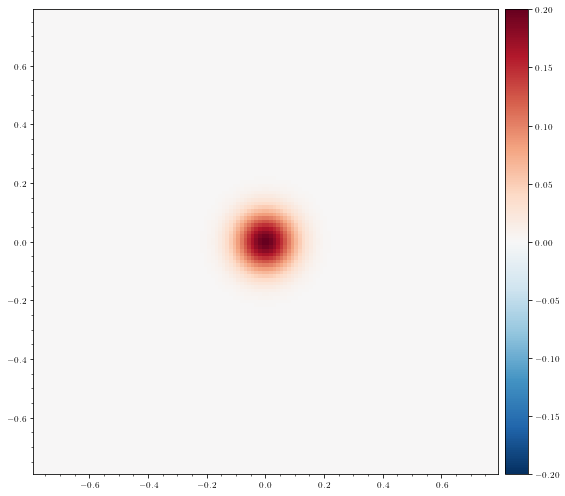

-2.094543143999118e-58

In [8]:
# Plot initial fields
%matplotlib inline

defrcparams(True)
fig_size=deffigsize(2.0,0.7)
ratio = 1.0

fig = P.figure(1, figsize = fig_size, facecolor = 'w')
ax = P.subplot(111)

f = P.pcolormesh(eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], Eru0[NG:(Nxi + NG), NG:(Neta + NG)] - B0, cmap = "RdBu_r", vmax = amp, vmin = - amp)
ax.set_aspect(1.0/ax.get_data_ratio()*ratio)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar=fig.colorbar(f,cax=cax)
cbar.ax.tick_params(labelsize=9)
cbar.ax.minorticks_off()

P.show()

N.max(B2u0)

In [9]:
def plot_fields_plane(it, field):
    
    fig_size=deffigsize(2.0,0.7)
    ratio = 1.0

    fig = P.figure(1, figsize = fig_size, facecolor = 'w')
    ax  = P.subplot(111)
    if (field=="Bru"):
        vm=B0 + amp
    else:
        vm = amp

    f = P.pcolormesh(eta_grid, xi_grid, (globals()[field]), cmap = "RdBu_r", vmin = vm - 2.0 * amp, vmax = vm)
    # f = P.pcolormesh(eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], (globals()[field])[NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = vm - 2.0 * amp, vmax = vm)
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    P.xlabel(r"$\xi$")
    P.xlabel(r"$\eta$")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=fig.colorbar(f,cax=cax)
    cbar.ax.tick_params(labelsize=9)
    cbar.ax.minorticks_off()

    figsave_png("snapshots/" + field + "_" + str(it))
    
    P.close("all")

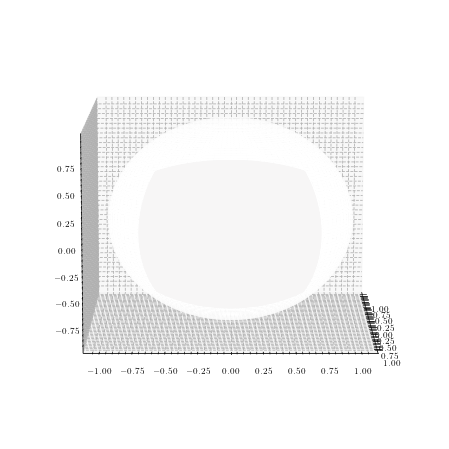

In [16]:
from matplotlib import cm
import matplotlib
%matplotlib inline

X = N.tan(xi_grid)
Y = N.tan(eta_grid)

phi_a = N.arctan2(X / N.sqrt(1+X**2), 1.0 / N.sqrt(1+X**2))
theta_a = 0.5 * N.pi - N.arctan(Y / N.sqrt(1.0 + X * X))

# phi_a = xi
# theta_a = 0.5 * N.pi - N.arctan(N.tan(eta) * N.cos(phi_a))
# theta_a_grid, phi_a_grid = N.meshgrid(theta_a, phi_a)

phi_b = 0.5 * N.pi + xi
theta_b = 0.5 * N.pi - N.arctan(N.tan(eta) * N.sin(phi_b))
phi_b_grid, theta_b_grid = N.meshgrid(phi_b, theta_b)

x_a = r * N.sin(theta_a) * N.cos(phi_a)
y_a = r * N.sin(theta_a) * N.sin(phi_a)
z_a = r * N.cos(theta_a)

phi_s = N.linspace(0, N.pi, 2*50)
theta_s = N.linspace(0, 2*N.pi, 2*50)
theta_s, phi_s = N.meshgrid(theta_s, phi_s)
x_s = 0.98 * N.sin(phi_s) * N.cos(theta_s)
y_s = 0.98 * N.sin(phi_s) * N.sin(theta_s)
z_s = 0.98 * N.cos(phi_s)

cmap_plot="RdBu_r"
norm_plot = matplotlib.colors.Normalize(vmin=- amp, vmax= amp)
m = cm.ScalarMappable(cmap=cmap_plot, norm=norm_plot)
m.set_array([])
fcolors = m.to_rgba(Eru0)

fig, ax = P.subplots(subplot_kw={"projection": "3d"}, figsize = (8,8))

ax.view_init(elev=10, azim=0)

f = ax.plot_surface(x_a[NG:(Nxi + NG - 1),NG:(Neta + NG - 1)], y_a[NG:(Nxi + NG - 1),NG:(Neta + NG - 1)], \
               z_a[NG:(Nxi + NG - 1),NG:(Neta + NG - 1)], 
               rstride=1, cstride=1, shade=False,
               facecolors=fcolors, norm = norm_plot)

# P.colorbar(m)

ax.plot_surface(x_s, y_s, z_s, rstride=1, cstride=1, shade=False, color = 'white')

ValueError: Argument Z must be 2-dimensional.

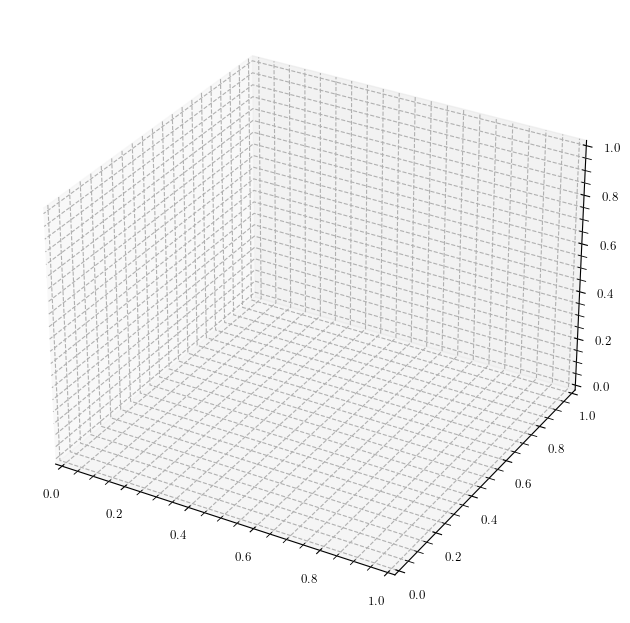

In [14]:
theta=N.zeros((Nxi,Neta))
phi=N.zeros((Nxi,Neta))
x=N.zeros((Nxi,Neta))
y=N.zeros((Nxi,Neta))
z=N.zeros((Nxi,Neta))

for i in range(Nxi):
    for j in range(Neta):
      X = N.tan(xi_min + i * dxi)
      Y = N.tan(eta_min + j * deta)

theta = N.pi/2.0 - N.arctan(Y/N.sqrt(1+X**2))
phi = N.arctan2(1/N.sqrt(1+X**2),X/N.sqrt(1+X**2))
      
x = N.sin(theta) * N.cos(phi)
y = -N.sin(theta) * N.sin(phi)
z = N.cos(theta)

fig, ax = P.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8), dpi=100)
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.nipy_spectral(Eru0), linewidth=0, shade=False)
ax.plot_surface(x_s, y_s, z_s, rstride=1, cstride=1, shade=False, color = 'white')

In [12]:
# Initialize simulation

Bru = Bru0
B1u = B1u0
B2u = B2u0
Eru = Eru0
E1u = E1u0
E2u = E2u0

BC_B_metal()
BC_E_metal()

iter = 0
idump = 0

B1d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

/tmp/ipykernel_435274/3573186761.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  f = P.pcolormesh(eta_grid, xi_grid, (globals()[field]), cmap = "RdBu_r", vmin = vm - 2.0 * amp, vmax = vm)
/tmp/ipykernel_435274/3573186761.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=fig.colorbar(f,cax=cax)


KeyboardInterrupt: 

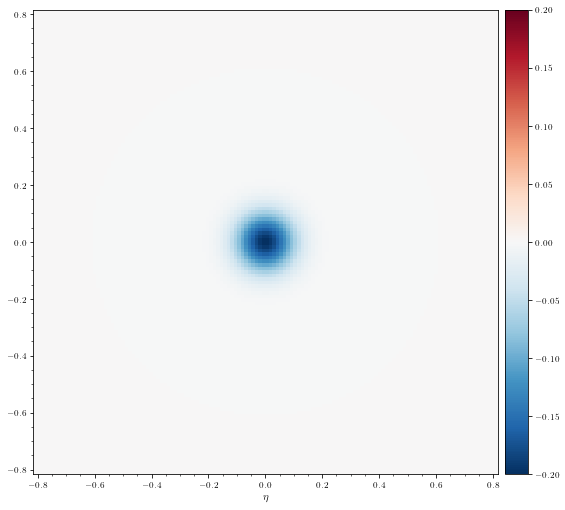

In [13]:
### Run the simulation
Nt = 1500 # Number of iterations
FDUMP = 10

for it in range(Nt):
    if ((it % FDUMP) == 0):
        plot_fields_plane(idump,"Eru")
        plot_fields_plane(idump,"B1u")
        plot_fields_plane(idump,"B2u")
        idump += 1

    print(it)
    iter += 1
    
    contra_to_cov_B()
    contra_to_cov_E()
        
    push_B()
    BC_B_metal()

    BC_B_absorb()

    push_E(it)
    BC_E_metal()
    BC_E_absorb()
    
    # push_B()
    # BC_B_periodic()
    # push_E(iter)
    # BC_E_periodic()